In [ ]:
! pip install streamlit pyngrok yfinance plotly
# !pip install pystan~=2.14
!pip install yfinance
!pip install ipython-autotime

In [ ]:
from pyngrok import ngrok

In [ ]:
ngrok.set_auth_token("2F4v40kJmMDVCfCU8WMCulOnT7d_pJt3w8ArHXju2ez8JGwi") #ngrok.com

In [ ]:
!nohup streamlit run app.py --server.port 80 &
url = ngrok.connect(port = '80')
print(url)

nohup: appending output to 'nohup.out'
NgrokTunnel: "http://c8e4-34-87-31-178.ngrok.io" -> "http://localhost:80"


In [ ]:
from pyngrok import ngrok

tunnels = ngrok.get_tunnels()
tunnels

# try:
#     # Block until CTRL-C or some other terminating event
#     ngrok_process.proc.wait()
# except KeyboardInterrupt:
#     print(" Shutting down server.")

#     ngrok.kill()

[<NgrokTunnel: "https://4b04-34-87-31-178.ngrok.io" -> "http://localhost:80">,
 <NgrokTunnel: "http://4b04-34-87-31-178.ngrok.io" -> "http://localhost:80">]

In [ ]:
!streamlit run /content/app.py & npx localtunnel --port 80

2022-10-17 08:24:38.399 INFO    numexpr.utils: NumExpr defaulting to 2 threads.
[..................] | fetchMetadata: sill resolveWithNewModule localtunnel@2.0


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.87.31.178:8501

npx: installed 22 in 3.451s
your url is: https://tender-experts-bathe-34-87-31-178.loca.lt
  Stopping...
^C


In [ ]:
x = !pgrep streamlit

# Creating a prediction system using streamlit framework with LSTM, GRU and Stacked model we trained on Bitcoin, Ethereum and Ripple

In [ ]:
%%writefile app.py

import streamlit as st
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import LSTM, LeakyReLU


import streamlit as st
from datetime import date

import yfinance as yf
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly
from plotly import graph_objs as go

from tensorflow.keras.models import load_model



st.title('Stock Forecast App')

stocks = ('BTC-USD', 'ETH-USD', 'XRP-USD')
selected_stock = st.selectbox('Select dataset for prediction', stocks)

n_days = st.slider('Days of prediction:', 1, 100)

@st.cache
def load_data(ticker):
    START = "2015-01-01"
    TODAY = date.today().strftime("%Y-%m-%d")
    
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

data_load_state = st.text('Loading data...')
data = load_data(selected_stock)
data_load_state.text('Loading data... done!')

st.subheader('Raw data')
st.write(data.tail())

#---------------------------- Plot raw data
def plot_raw_data():
	fig = go.Figure()
	fig.add_trace(go.Scatter(x=data['Date'], y=data['Open'], name="open price"))
	fig.add_trace(go.Scatter(x=data['Date'], y=data['Close'], name="close price"))
	fig.layout.update(title_text='Time Series data with Rangeslider', xaxis_rangeslider_visible=True)
	st.plotly_chart(fig)
		
plot_raw_data()

#--------------------------- forcasting
# load models
LSTM_path = '/content/drive/My Drive/Models/LSTM_best_model.hdf5'
GRU_path = '/content/drive/My Drive/Models/GRU_best_model.hdf5'
meta_path = '/content/drive/My Drive/Models/meta_best_model.hdf5'

loaded_LSTM = load_model(LSTM_path)
loaded_GRU = load_model(GRU_path)
loaded_meta = load_model(meta_path)

LSTM_model = loaded_LSTM
GRU_model = loaded_GRU
meta_model = loaded_meta

# make predictions

def forcasting(n_days):
	n_steps = 10

	scaler_test = MinMaxScaler(feature_range=(0, 1))
	scaled_test = scaler_test.fit_transform(data['Close'][-n_steps:].values.reshape(-1,1))

	prediction_period = n_days
	temp_input = scaled_test
	x_input = scaled_test
	# demonstrate prediction for next 10 days
	from numpy import array

	lst_output=[]

	i=0
	while(i<prediction_period):
			
			if(len(temp_input)>n_steps):
					# print(temp_input)
					x_input=np.array(temp_input[1:])
					# print("{} day input {}".format(i,x_input))
					x_input=x_input.reshape(1,-1)
					x_input = x_input.reshape((1, n_steps, 1))
					#print(x_input)
					# yhat = model_from_saved_checkpoint.predict(x_input, verbose=0)
					yhat1 = LSTM_model.predict(x_input, verbose=0)
					yhat2 = GRU_model.predict(x_input, verbose=0)
					level1_test_data = np.concatenate((yhat1, yhat2), axis=-1)
					yhat = meta_model.predict(level1_test_data)

					
					# print("x = ", x_input)
					# print("{} day output {}".format(i,yhat))
					# temp_input.extend(yhat[0].tolist())
					temp_input = np.append(temp_input, yhat[0])
					temp_input=temp_input[1:]
					#print(temp_input)
					lst_output.extend(yhat.tolist())
					i=i+1
			else:
					x_input = x_input.reshape((1, n_steps,1))
					# yhat = model_from_saved_checkpoint.predict(x_input, verbose=0)
					yhat1 = LSTM_model.predict(x_input, verbose=0)
					yhat2 = GRU_model.predict(x_input, verbose=0)
					level1_test_data = np.concatenate((yhat1, yhat2), axis=-1)
					yhat = meta_model.predict(level1_test_data)
					
					# print(yhat[0])
					# temp_input.extend(yhat[0].tolist())
					temp_input = np.append(temp_input, yhat[0])
					lst_output.extend(yhat.tolist())
					i=i+1
			

	lst_output = np.array(lst_output)
	lst_output = scaler_test.inverse_transform(lst_output.reshape(-1, 1))

	return lst_output

predicttion = forcasting(n_days)

st.subheader('predicted price')

st.write(pd.DataFrame(predicttion)[0])

def plot_raw_data():
	x_array = np.arange(1 , n_days + 1)
	fig = go.Figure()
	fig.add_trace(go.Scatter(x=x_array, y=pd.DataFrame(predicttion)[0], name="predicted price"))
	# fig.layout.update(title_text='Time Series data with Rangeslider', xaxis_rangeslider_visible=True)
	st.plotly_chart(fig)

plot_raw_data()

st.write("finished")

Writing app.py


In [ ]:
ngrok.kill()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

%pip install Historic_Crypto
from Historic_Crypto import HistoricalData

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# %time btc_historicals = HistoricalData('BTC-USD',60,'2015-08-01-00-00', '2022-07-26-00-00').retrieve_data()
# btc_historicals.head()

In [ ]:
# len(btc_historicals)

In [ ]:
# #Write Data

# from google.colab import files
# # btc_historicals.to_csv('btc_historicals_2015-08-01-00-00_2022-07-18-00-00.csv') 
# # files.download('btc_historicals_2015-08-01-00-00_2022-07-18-00-00.csv')

# from google.colab import drive

# drive.mount('/content/drive')
# path = '/content/drive/My Drive/btc_historicals_2015-08-01-00-00_2022-07-18-00-00.csv'

# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   btc_historicals.to_csv(f)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import binary_focal_crossentropy

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import LSTM, LeakyReLU, Bidirectional

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Google Drive Root Path
root_path = '/content/drive/My Drive/Copy of btc_historicals_2015-08-01-00-00_2022-07-18-00-00.csv'

# Local Machine Root Path
# root_path = './input/btc_ohlc_Oct_2015_to_Oct_2021.csv'

# Kaggle Root Path
# root_path = '/kaggle/input/bitcoin-historic-prices-from-oct2015-to-oct2021/btc_ohlc_Oct_2015_to_Oct_2021.csv'


# btc_input_df = pd.read_csv(root_path, nrows=500)
btc_input_df = pd.read_csv(root_path)

# btc_input_df = btc_historicals
btc_input_df.tail()

In [ ]:
btc_input_df.shape

In [ ]:
btc_input_df.describe()

,low,high,open,close,volume
count,3.613022e+06,3.613022e+06,3.613022e+06,3.613022e+06,3.613022e+06
mean,1.419965e+04,1.421668e+04,1.420827e+04,1.420830e+04,9.863602e+00
std,1.697359e+04,1.699594e+04,1.698482e+04,1.698485e+04,2.177076e+01
min,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,1.000000e-08
25%,2.209122e+03,2.212562e+03,2.211030e+03,2.211003e+03,1.439860e+00
50%,7.653520e+03,7.660000e+03,7.656730e+03,7.656730e+03,3.997861e+00
75%,1.659099e+04,1.661899e+04,1.660274e+04,1.660310e+04,1.020096e+01
max,6.878669e+04,6.900000e+04,6.899776e+04,6.899776e+04,1.549613e+03


In [ ]:
btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613022 entries, 0 to 3613021
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    object 
 1   low     float64
 2   high    float64
 3   open    float64
 4   close   float64
 5   volume  float64
dtypes: float64(5), object(1)
memory usage: 165.4+ MB


In [ ]:
btc_input_df_datetype = btc_input_df.astype({'time': 'datetime64'})

In [ ]:
btc_input_df_datetype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613022 entries, 0 to 3613021
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   low     float64       
 2   high    float64       
 3   open    float64       
 4   close   float64       
 5   volume  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 165.4 MB


In [ ]:
print('Null Values:',btc_input_df_datetype.isnull().values.sum())
print('If any NA values:', btc_input_df_datetype.isnull().values.any())

Null Values: 0
If any NA values: False


In [ ]:
btc_input_df_datetype.tail()

,time,low,high,open,close,volume
3613017,2022-07-25 23:56:00,21291.13,21331.61,21297.80,21327.39,17.155631
3613018,2022-07-25 23:57:00,21298.33,21345.75,21327.36,21309.08,37.797065
3613019,2022-07-25 23:58:00,21308.03,21328.65,21309.08,21321.67,6.614248
3613020,2022-07-25 23:59:00,21275.65,21328.60,21321.92,21313.41,50.148258
3613021,2022-07-26 00:00:00,21234.01,21317.17,21312.06,21248.31,111.412603


In [ ]:
btc_input_df_datetype.head()

,time,low,high,open,close,volume
0,2015-08-01 00:00:00,284.89,285.25,285.20,284.89,6.2942
1,2015-08-01 00:01:00,284.82,285.30,285.08,284.82,3.0171
2,2015-08-01 00:02:00,285.13,285.39,285.18,285.39,4.3034
3,2015-08-01 00:03:00,285.28,285.28,285.28,285.28,0.1786
4,2015-08-01 00:04:00,285.23,285.25,285.25,285.25,1.1925


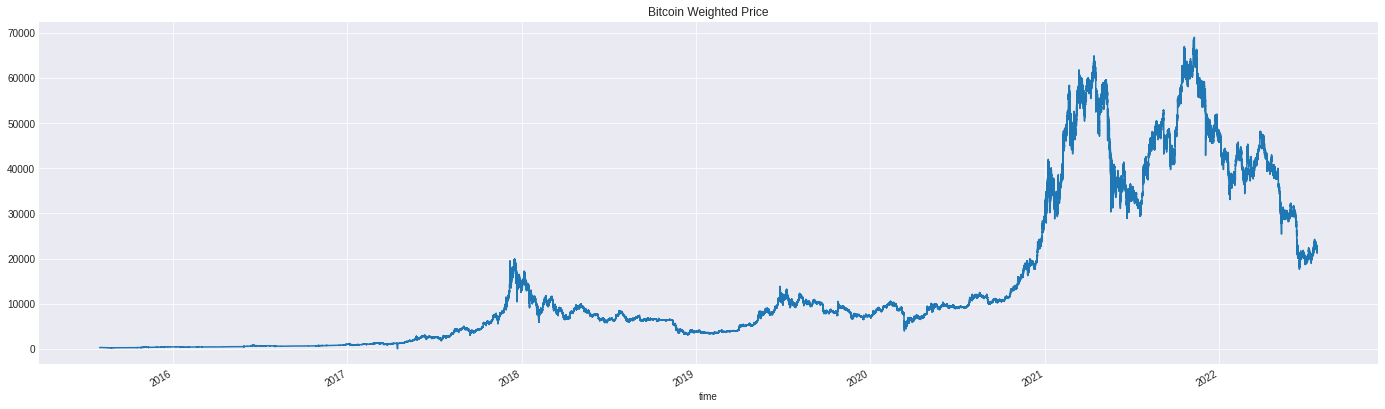

In [ ]:
btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [ ]:
btc_input_df_datetype.set_index("time").close


time
2015-08-01 00:00:00      284.89
2015-08-01 00:01:00      284.82
2015-08-01 00:02:00      285.39
2015-08-01 00:03:00      285.28
2015-08-01 00:04:00      285.25
                         ...   
2022-07-25 23:56:00    21327.39
2022-07-25 23:57:00    21309.08
2022-07-25 23:58:00    21321.67
2022-07-25 23:59:00    21313.41
2022-07-26 00:00:00    21248.31
Name: close, Length: 3613022, dtype: float64

In [ ]:
x = btc_input_df_datetype.close.values
x

array([  284.89,   284.82,   285.39, ..., 21321.67, 21313.41, 21248.31])

In [ ]:
# import streamlit as st
from datetime import date

import yfinance as yf
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly
from plotly import graph_objs as go



def load_data(ticker):
    START = "2015-01-01"
    TODAY = date.today().strftime("%Y-%m-%d")
    
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

selected_stock = "XRP-USD"
data = load_data(selected_stock)
data


[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09 00:00:00+00:00,0.217911,0.221791,0.214866,0.217488,0.217488,147916992
1,2017-11-10 00:00:00+00:00,0.218256,0.219068,0.205260,0.206483,0.206483,141032992
2,2017-11-11 00:00:00+00:00,0.205948,0.214456,0.205459,0.210430,0.210430,134503008
3,2017-11-12 00:00:00+00:00,0.210214,0.210214,0.195389,0.197339,0.197339,251175008
4,2017-11-13 00:00:00+00:00,0.197472,0.204081,0.197456,0.203442,0.203442,132567000
...,...,...,...,...,...,...,...
1792,2022-10-06 00:00:00+00:00,0.489699,0.504087,0.489372,0.493184,0.493184,1913140571
1793,2022-10-07 00:00:00+00:00,0.493277,0.521646,0.484205,0.518278,0.518278,2627481992
1794,2022-10-08 00:00:00+00:00,0.518225,0.527902,0.514383,0.517113,0.517113,1771062053
1795,2022-10-09 00:00:00+00:00,0.517149,0.541416,0.508167,0.534061,0.534061,1789206998


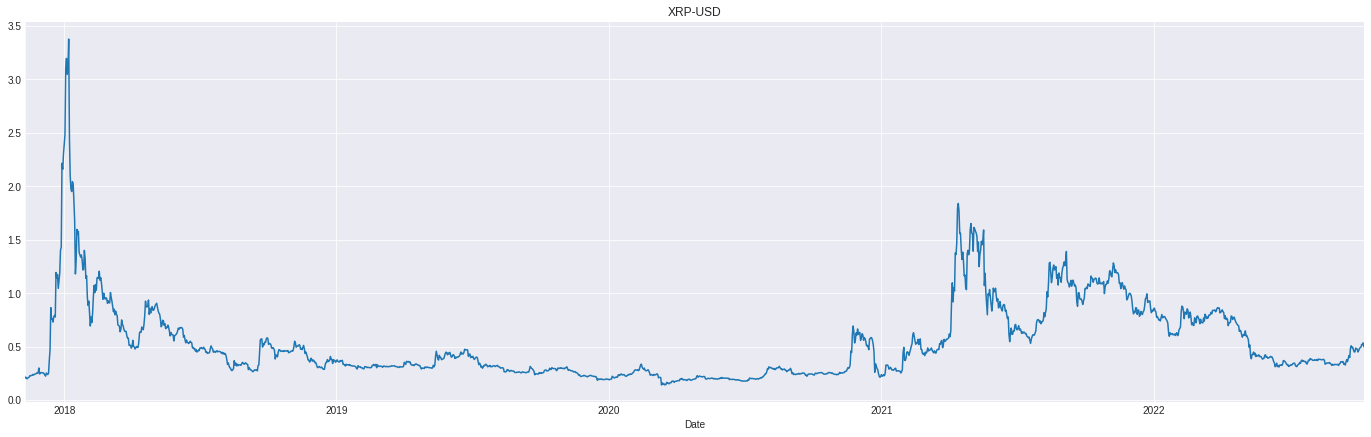

In [ ]:
data.set_index("Date").Close.plot(figsize=(24,7), title=selected_stock)

In [ ]:
data.Close

0         314.248993
1         315.032013
2         281.082001
3         264.195007
4         274.473999
            ...     
2835    19955.443359
2836    19546.849609
2837    19416.568359
2838    19446.425781
2839    19141.484375
Name: Close, Length: 2840, dtype: float64

# Lag Plot


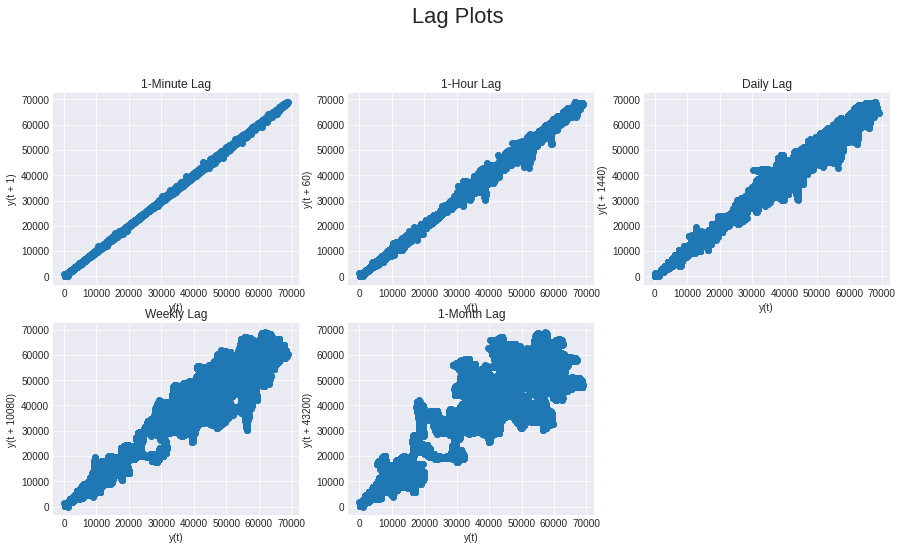

In [ ]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

We can see that there is a positive correlation for minute, hour and daily lag plots. 

Something else to consider is that price might flactuate a lot in small time periods like minute and hour and we might see fake changes. So for the purpose of this project we will only focus on daily time period.

In [ ]:
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['time'],unit='s').dt.date

group = btc_input_df_datetype.groupby('date')

btc_closing_price_groupby_date = group['close'].mean()

In [ ]:
btc_closing_price_groupby_date = btc_closing_price_groupby_date.reset_index()
btc_closing_price_groupby_date['date']

# print("Length of btc_closing_price_groupby_date :", len(btc_closing_price_groupby_date))

# Train Test Split

In [ ]:
validation_size = int(((len(data)*0.1)/10))*10
test_size = int(((len(data)*0.1)/10))*10

# Set Train data to be uplo ( Total data length - prediction_days )
df_train= data['Close'][:len(data['Close'])-test_size-validation_size].values.reshape(-1,1)

# Set Test data to be the last prediction_days (or 60 days in this case)
df_validation= data['Close'][len(data['Close'])-test_size-validation_size:len(data['Close'])-test_size].values.reshape(-1,1)

df_test= data['Close'][len(data['Close'])-test_size:].values.reshape(-1,1)

print(df_train.shape)
print(df_validation.shape)
print(df_test.shape)

(1457, 1)
(170, 1)
(170, 1)


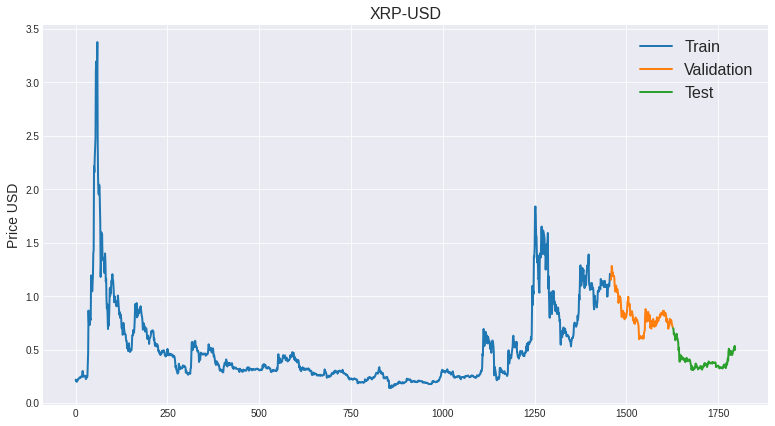

In [ ]:
new_train = pd.DataFrame(df_train)
new_train.columns = ['train']

# Retrieve index values
val_index = new_train['train'].tail(len(df_validation)).index + len(df_validation)
test_index = new_train['train'].tail(len(df_test)).index + len(df_validation) + len(df_test)

# Make a dataframe with your prediction values and your index
new_val = pd.DataFrame(index = val_index, data = df_validation)
new_test = pd.DataFrame(index = test_index, data = df_test)


fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(new_train, label='Train', linewidth=2)
ax.plot(new_val, label='Validation', linewidth=2)
ax.plot(new_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title(selected_stock, fontsize=16)
ax.legend(loc='best', fontsize=16)


In [ ]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_validation = MinMaxScaler(feature_range=(0, 1))
scaled_validation = scaler_validation.fit_transform(df_validation)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [ ]:
def dataset_generator_lstm(dataset, look_back=100):
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep. 
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

validationX, validationY = dataset_generator_lstm(scaled_validation)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("validationX: ", validationX.shape)
print("validationY: ", validationY.shape)
print("testY: ", testX.shape)
print("testY", testY.shape)

trainX:  (1357, 100)
trainY:  (1357,)
validationX:  (70, 100)
validationY:  (70,)
testY:  (70, 100)
testY (70,)


In [ ]:
trainX

array([[0.02404225, 0.02064373, 0.02186262, ..., 0.30942894, 0.31104712,
        0.30832029],
       [0.02064373, 0.02186262, 0.01781991, ..., 0.31104712, 0.30832029,
        0.3289955 ],
       [0.02186262, 0.01781991, 0.01970462, ..., 0.30832029, 0.3289955 ,
        0.30289439],
       ...,
       [0.14413118, 0.15007928, 0.15594248, ..., 0.29161919, 0.3006669 ,
        0.29437323],
       [0.15007928, 0.15594248, 0.18090745, ..., 0.3006669 , 0.29437323,
        0.30775391],
       [0.15594248, 0.18090745, 0.18787805, ..., 0.29437323, 0.30775391,
        0.33017395]])

In [ ]:
trainY

array([0.3289955 , 0.30289439, 0.31029362, ..., 0.30775391, 0.33017395,
       0.32807616])

-------------------------------

# Prepare data in 3D shape of [samples, time steps, features] to train LSTM model

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

validationX = np.reshape(validationX, (validationX.shape[0], validationX.shape[1], 1 ))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of validationX: ", validationX.shape)
print("Shape of testX: ", testX.shape)

input_shape = (trainX.shape[1], trainX.shape[2])
print("Layer input shape: ", input_shape)


Shape of trainX:  (1357, 100, 1)
Shape of validationX:  (70, 100, 1)
Shape of testX:  (70, 100, 1)
Layer input shape:  (100, 1)


In [ ]:
# First checking the values for input_shape = (trainX.shape[1], trainX.shape[2])
# Note - `input_shape` of LSTM Model - `input_shape` is supposed to be (timesteps, n_features).

print("trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features) ", trainX.shape[1])
print("trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features) ", trainX.shape[2])

trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features)  100
trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features)  1


In [ ]:
input_shape = (trainX.shape[1], trainX.shape[2])

In [ ]:
LSTM_model = Sequential()

LSTM_model.add(LSTM(units = 128, return_sequences = False, input_shape = (trainX.shape[1], trainX.shape[2])))
# LSTM_model.add(Dropout(0.1))

# LSTM_model.add(LSTM(units = 64, return_sequences = False))
# LSTM_model.add(Dropout(0.1))

# LSTM_model.add(LSTM(units = 50, return_sequences = False))



# LSTM_model.add(Dropout(0.1))

# LSTM_model.add(LSTM(units = 64, return_sequences = False))

# LSTM_model.add(Dropout(0.2))
# LSTM_model.add(Dense(units = 32))

# LSTM_model.add(Dense(units = 8))

LSTM_model.add(Dense(units = 1))



# Adding the first LSTM layer and some Dropout regularisation
# You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer
# has a compatible n-dimensional sequence input.
# This hyper parameter should be set to False (which is the default value) for the last layer
# and true for the other previous layers.

# regressor.add(LSTM(units = 128, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# LSTM_model.add(LSTM(units = 128, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# LSTM_model.add(Dropout(0.2))
# # # Adding a second LSTM layer and some Dropout regularisation

# LSTM_model.add(LSTM(units = 64, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# LSTM_model.add(Dropout(0.2))

# LSTM_model.add(LSTM(units = 32, input_shape = (trainX.shape[1], trainX.shape[2])))
# LSTM_model.add(Dropout(0.2))

# LSTM_model.add(LSTM(units = 5, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# # LSTM_model.add(Activation('tanh'))
# LSTM_model.add(LSTM(units = 5, input_shape = (trainX.shape[1], trainX.shape[2])))

# LSTM_model.add(Dense(units = 1))
# LSTM_model.add(LeakyReLU())

# LSTM_model.add(LSTM(units = 50, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2]), activation='relu'))
# LSTM_model.add(LSTM(units = 50, activation='relu'))
# LSTM_model.add(Dense(units = 1))


# LSTM_model.add(LSTM(units = 16, input_shape = (trainX.shape[1], trainX.shape[2])))

# LSTM_model.add(Dropout(0.2))
# LSTM_model.add(LSTM(units = 50, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# LSTM_model.add(Dropout(0.2))
# LSTM_model.add(LSTM(units = 50, input_shape = (trainX.shape[1], trainX.shape[2])))
# LSTM_model.add(Dropout(0.2))

# LSTM_model.add(Activation('linear'))


#--------
# from keras import regularizers
# from keras.layers import LSTM, LeakyReLU, CuDNNLSTM
# from keras.layers import Dense, Dropout, Activation, Flatten,Reshape
# regressor = Sequential()
# regressor.add(LSTM(units=50, activity_regularizer=regularizers.l1(1), input_shape = (trainX.shape[1], trainX.shape[2]),return_sequences=False))
# regressor.add(Activation('tanh'))
# regressor.add(Dropout(0.2))
# regressor.add(Dense(units = 1))
# regressor.add(LeakyReLU())
#--------


# Note - If I plan to add 3-rd or 4-th layers of LSTM then 
# I must set return_sequences=True in the 2-nd layer above
# so that the 3-rd LSTM layer has a compatible n-dimensional sequence input.


# Adding a third LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))

# DROPOUT = 0.2
# SEQ_LEN = 10
# WINDOW_SIZE = SEQ_LEN - 1

# LSTM_model.add(Bidirectional(
#   LSTM(WINDOW_SIZE, return_sequences=True),
#   input_shape= (trainX.shape[1], trainX.shape[2])
# ))
# LSTM_model.add(Dropout(rate=DROPOUT))

# LSTM_model.add(Bidirectional(
#   LSTM((WINDOW_SIZE * 2), return_sequences=True)
# ))
# LSTM_model.add(Dropout(rate=DROPOUT))

# LSTM_model.add(Bidirectional(
#   LSTM(WINDOW_SIZE, return_sequences=False)
# ))

# LSTM_model.add(Dense(units=1))

# LSTM_model.add(Activation('linear'))


# LSTM_model.add(LSTM(units = 128, return_sequences = False, input_shape = (trainX.shape[1], trainX.shape[2])))
# LSTM_model.add(Dropout(0.2))
# LSTM_model.add(Dense(units = 1))

# LSTM_model.summary()

# Adding a fourth LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding the output layer


# my_LSTM_model = Sequential()
# regressor.add(LSTM(units=50, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2]), activation='tanh'))
# regressor.add(LSTM(units=50, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2]), activation='tanh'))
# regressor.add(LSTM(units=50, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2]), activation='tanh'))
# regressor.add(LSTM(units=50, activation='tanh'))
# regressor.add(Dropout(0.2))
# regressor.add(Dense(units=1))

LSTM_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

LSTM_path = 'LSTM_best_model.hdf5'
LSTM_path = selected_stock + "_" + LSTM_path


LSTM_checkpoint = ModelCheckpoint(filepath=LSTM_path, 
                             monitor='val_loss',
                             verbose=1, 
                              save_best_only=True,
                             mode='min')

LSTM_earlystopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

LSTM_callbacks = [LSTM_checkpoint, LSTM_earlystopping]

time: 1.33 ms (started: 2022-10-11 19:05:06 +00:00)


In [ ]:
LSTM_model.compile(optimizer = 'adam', loss = 'mean_squared_error')


%load_ext autotime
LSTM_history = LSTM_model.fit(trainX,
                              trainY, 
                              batch_size = 8,
                              epochs = 200, 
                              verbose=1,
                              shuffle=False, 
                              validation_data=(validationX, validationY), 
                              callbacks=LSTM_callbacks)

In [ ]:
x = selected_stock + "_" + LSTM_path
LSTM_path

In [ ]:
# from tensorflow.keras.models import load_model

# loaded_LSTM = load_model(LSTM_path)

In [ ]:
# import shutil
# shutil.copy(LSTM_path,'/content/drive/My Drive')

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(LSTM_history.history['loss'], label='train')

plt.plot(LSTM_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
# LSTM_model = loaded_LSTM

LSTM_predicted_val = LSTM_model.predict(validationX)
LSTM_predicted_val = scaler_validation.inverse_transform(LSTM_predicted_val.reshape(-1, 1))
LSTM_predicted_test = LSTM_model.predict(testX)
LSTM_predicted_test = scaler_test.inverse_transform(LSTM_predicted_test.reshape(-1, 1))
LSTM_predicted_train = LSTM_model.predict(trainX)
LSTM_predicted_train = scaler_train.inverse_transform(LSTM_predicted_train.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))
test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))
validation_actual = scaler_validation.inverse_transform(validationY.reshape(-1, 1))


rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, LSTM_predicted_train))
mape_lstm_train = mean_absolute_percentage_error(train_actual, LSTM_predicted_train)

print('LSTM_train RMSE: %.3f' % rmse_lstm_train)
print('LSTM_train MAPE: %.3f' % mape_lstm_train)

rmse_lstm_test = math.sqrt(mean_squared_error(validation_actual, LSTM_predicted_val))
mape_lstm_test = mean_absolute_percentage_error(validation_actual, LSTM_predicted_val)

print('LSTM_val RMSE: %.3f' % rmse_lstm_test)
print('LSTM_val MAPE: %.3f' % mape_lstm_test)

rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, LSTM_predicted_test))
mape_lstm_test = mean_absolute_percentage_error(test_actual, LSTM_predicted_test)

print('LSTM_test RMSE: %.3f' % rmse_lstm_test)
print('LSTM_test MAPE: %.3f' % mape_lstm_test)


plt.figure(figsize=(16,7))

plt.plot(LSTM_predicted_test, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [ ]:
# predicted_btc_price_train_data = LSTM_model.predict(trainX)

# predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

# train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

# plt.figure(figsize=(16,7))

# plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

# plt.plot(train_actual, marker='.', label='Actual Train')

# plt.legend()
# plt.show()

# rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))
# mape_lstm_train = mean_absolute_percentage_error(train_actual, predicted_btc_price_train_data)

# print('Train RMSE: %.3f' % rmse_lstm_train)
# print('Train MAPE: %.3f' % mape_lstm_train)

In [ ]:
# create a model
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU
from keras.layers import Dropout, LeakyReLU


# The GRU architecture
GRU_model = Sequential()

GRU_model.add(GRU(units=64, return_sequences=False, input_shape = (trainX.shape[1], trainX.shape[2])))
# GRU_model.add(GRU(units=50, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# GRU_model.add(GRU(units=50, return_sequences=False, input_shape = (trainX.shape[1], trainX.shape[2])))


GRU_model.add(Dropout(0.2))
GRU_model.add(Dense(units = 1))


# First GRU layer with Dropout regularisation
# GRU_model.add(GRU(units=256, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# GRU_model.add(Dropout(0.2))
# GRU_model.add(GRU(units=64, input_shape = (trainX.shape[1], trainX.shape[2])))
#-----------------------------------


# GRU_model.add(GRU(units=18, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# GRU_model.add(Dropout(0.1))
# GRU_model.add(GRU(units=18, return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# GRU_model.add(LSTM(units=9, input_shape = (trainX.shape[1], trainX.shape[2])))


# GRU_model.add(Dropout(0.2))
#--------

# Second GRU layer
# GRU_model.add(GRU(units=50, return_sequences=True))
# GRU_model.add(Dropout(0.2))

# Third GRU layer
# GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
# GRU_model.add(Dropout(0.2))
# Fourth GRU layer
# GRU_model.add(GRU(units=50))
# GRU_model.add(Dropout(0.1))
# The output layer
# GRU_model.add(Dense(units=1))
# # Compiling the RNN
# my_GRU_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# # Fitting to the training set
# my_GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

# GRU_predictions = my_GRU_model.predict(X_test)
# GRU_predictions = sc.inverse_transform(GRU_predictions)

# return my_GRU_model, GRU_predictions
# my_GRU_model, GRU_predictions = GRU_model_regularization(X_train, y_train, X_test, sc)
# GRU_predictions[1:10]
# actual_pred_plot(GRU_prediction)  
GRU_model.summary()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

GRU_path = 'GRU_best_model.hdf5'

GRU_checkpoint = ModelCheckpoint(filepath=GRU_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

GRU_earlystopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

GRU_callbacks = [GRU_checkpoint, GRU_earlystopping]

In [ ]:
GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

GRU_history = GRU_model.fit(trainX, trainY, batch_size = 8, epochs = 200, verbose=1, shuffle=False, validation_data=(validationX, validationY), callbacks=GRU_callbacks)

In [ ]:
# from tensorflow.keras.models import load_model

# loaded_GRU = load_model(GRU_path)

In [ ]:
# import shutil
# shutil.copy(meta_path,'/content/drive/My Drive/Models')

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(GRU_history.history['loss'], label='train')

plt.plot(GRU_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
# GRU_model = loaded_GRU

GRU_predicted_val = GRU_model.predict(validationX)
GRU_predicted_val = scaler_validation.inverse_transform(GRU_predicted_val.reshape(-1, 1))
GRU_predicted_test = GRU_model.predict(testX)
GRU_predicted_test = scaler_test.inverse_transform(GRU_predicted_test.reshape(-1, 1))
GRU_predicted_train = GRU_model.predict(trainX)
GRU_predicted_train = scaler_train.inverse_transform(GRU_predicted_train.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))
test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))
validation_actual = scaler_validation.inverse_transform(validationY.reshape(-1, 1))


rmse_GRU_train = math.sqrt(mean_squared_error(train_actual, GRU_predicted_train))
mape_GRU_train = mean_absolute_percentage_error(train_actual, GRU_predicted_train)

print('GRU_train RMSE: %.3f' % rmse_GRU_train)
print('GRU_train MAPE: %.3f' % mape_GRU_train)

rmse_GRU_test = math.sqrt(mean_squared_error(validation_actual, GRU_predicted_val))
mape_GRU_test = mean_absolute_percentage_error(validation_actual, GRU_predicted_val)

print('GRU_val RMSE: %.3f' % rmse_GRU_test)
print('GRU_val MAPE: %.3f' % mape_GRU_test)

rmse_GRU_test = math.sqrt(mean_squared_error(test_actual, GRU_predicted_test))
mape_GRU_test = mean_absolute_percentage_error(test_actual, GRU_predicted_test)

print('GRU_test RMSE: %.3f' % rmse_GRU_test)
print('GRU_test MAPE: %.3f' % mape_GRU_test)


plt.figure(figsize=(16,7))

plt.plot(GRU_predicted_test, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [ ]:
# Transformation to original form and making the predictions

# predicted_btc_price_test_data = regressor.predict(testX)
# LSTM_predicted_val = LSTM_model.predict(validationX)
# GRU_predicted_val = GRU_model.predict(validationX)

# LSTM_predicted_val = scaler_validation.inverse_transform(LSTM_predicted_val.reshape(-1, 1))
# GRU_predicted_val = scaler_validation.inverse_transform(GRU_predicted_val.reshape(-1, 1))

# LSTM_predicted_test = LSTM_model.predict(testX)
# GRU_predicted_test = GRU_model.predict(testX)

# LSTM_predicted_test = scaler_test.inverse_transform(LSTM_predicted_test.reshape(-1, 1))
# GRU_predicted_test = scaler_test.inverse_transform(GRU_predicted_test.reshape(-1, 1))

# test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))
# validation_actual = scaler_validation.inverse_transform(validationY.reshape(-1, 1))

time: 578 µs (started: 2022-10-11 19:11:30 +00:00)


In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(validation_actual, LSTM_predicted_val))
mape_lstm_test = mean_absolute_percentage_error(validation_actual, LSTM_predicted_val)

print('LSTM_val RMSE: %.3f' % rmse_lstm_test)
print('LSTM_val MAPE: %.3f' % mape_lstm_test)

rmse_lstm_test = math.sqrt(mean_squared_error(validation_actual, GRU_predicted_val))
mape_lstm_test = mean_absolute_percentage_error(validation_actual, GRU_predicted_val)

print('GRU_val RMSE: %.3f' % rmse_lstm_test)
print('GRU_val MAPE: %.3f' % mape_lstm_test)



rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, LSTM_predicted_test))
mape_lstm_test = mean_absolute_percentage_error(test_actual, LSTM_predicted_test)

print('LSTM_test RMSE: %.3f' % rmse_lstm_test)
print('LSTM_test MAPE: %.3f' % mape_lstm_test)

rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, GRU_predicted_test))
mape_lstm_test = mean_absolute_percentage_error(test_actual, GRU_predicted_test)

print('GRU_test RMSE: %.3f' % rmse_lstm_test)
print('GRU_test MAPE: %.3f' % mape_lstm_test)

LSTM_val RMSE: 0.002
LSTM_val MAPE: 0.002
GRU_val RMSE: 0.002
GRU_val MAPE: 0.002
LSTM_test RMSE: 0.022
LSTM_test MAPE: 0.048
GRU_test RMSE: 0.019
GRU_test MAPE: 0.034
time: 6.64 ms (started: 2022-10-11 19:11:30 +00:00)


# Stacking LSTM and GRU model by training a meta model

In [ ]:
# Generate generic sequential model.
from tensorflow.keras import activations

meta_model = Sequential()

# Desired activation function.
activ_func = LeakyReLU()

# Set input layer and size.
meta_model.add(Flatten(input_shape=(2,)))

# Hidden Layer 1
meta_model.add(Dense(16, activation = activ_func))

# Hidden Layer 2
meta_model.add(Dense(8, activation = activ_func))

# Output Layer
meta_model.add(Dense(1))

meta_model.summary()


# # Hidden Layer 3
# meta_model.add(Dense(2, activation = activ_func))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2)                 0         
                                                                 
 dense_9 (Dense)             (None, 16)                48        
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________
time: 63.2 ms (started: 2022-10-11 19:11:30 +00:00)


In [ ]:
# Normalize X validation data.
normalized_x_validation1 = scaler_validation.fit_transform(LSTM_predicted_val)
normalized_x_validation2 = scaler_validation.fit_transform(GRU_predicted_val)

# Normalize Y validation data.
normalized_y_validation = scaler_validation.fit_transform(validation_actual)

# Concate training data.
level1_train_data = np.concatenate((normalized_x_validation1, normalized_x_validation2), axis=-1)

time: 2.13 ms (started: 2022-10-11 19:11:30 +00:00)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

stack_path = 'stack_best_model.hdf5'

stack_checkpoint = ModelCheckpoint(filepath=stack_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

stack_earlystopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

stack_callbacks = [stack_checkpoint, stack_earlystopping]

time: 1.58 ms (started: 2022-10-11 19:11:30 +00:00)


In [ ]:
# Compile model.
meta_model.compile(optimizer='adam',loss='mean_squared_error')

# Fit model to training data.
meta_history = meta_model.fit(level1_train_data, normalized_y_validation, epochs = 200, batch_size = 8)

Epoch 1/200
9/9 [==============================] - 0s 3ms/step - loss: 0.3869
Epoch 2/200
9/9 [==============================] - 0s 3ms/step - loss: 0.3152
Epoch 3/200
9/9 [==============================] - 0s 3ms/step - loss: 0.2512
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 0.1771
Epoch 5/200
9/9 [==============================] - 0s 3ms/step - loss: 0.1092
Epoch 6/200
9/9 [==============================] - 0s 4ms/step - loss: 0.0664
Epoch 7/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0456
Epoch 8/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0428
Epoch 9/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0429
Epoch 10/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0419
Epoch 11/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0406
Epoch 12/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0395
Epoch 13/200
9/9 [==============================] - 0s 3ms/st

In [ ]:
# Save the entire model as a SavedModel.
# !mkdir -p saved_model

meta_path = 'meta_best_model.hdf5'

meta_model.save(meta_path)

time: 24.7 ms (started: 2022-10-11 19:11:41 +00:00)


In [ ]:
from tensorflow.keras.models import load_model

loaded_stack = load_model(meta_path)

time: 399 ms (started: 2022-10-11 19:11:41 +00:00)


In [ ]:
dff_output_model = loaded_stack

time: 1.17 ms (started: 2022-10-11 19:11:41 +00:00)


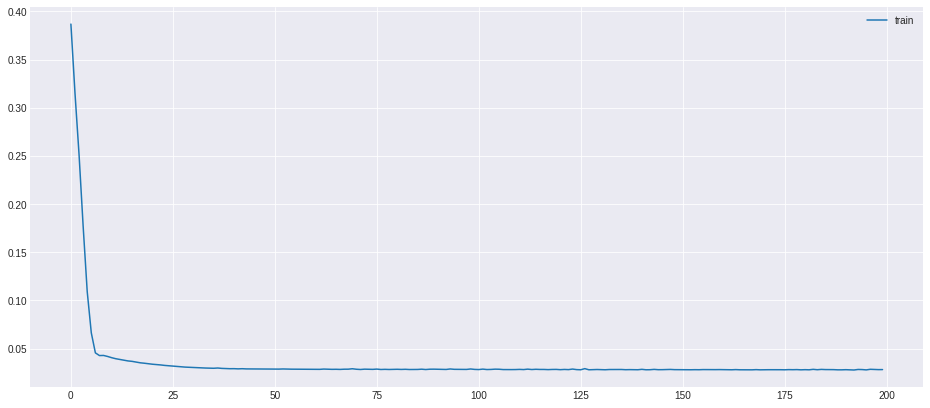

time: 176 ms (started: 2022-10-11 19:11:41 +00:00)


In [ ]:
plt.figure(figsize=(16,7))
plt.plot(meta_history.history['loss'], label='train')

# plt.plot(meta_history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# Normalize test data.
scaler = MinMaxScaler(feature_range=(0, 1))

normalized_x_test1 = scaler.fit_transform(LSTM_predicted_test)
normalized_x_test2 = scaler.fit_transform(GRU_predicted_test)

# Concatanate the test data.
level1_test_data = np.concatenate((normalized_x_test1, normalized_x_test2), axis=-1)

time: 2.01 ms (started: 2022-10-11 19:11:42 +00:00)


In [ ]:
Xt3 = dff_output_model.predict(level1_test_data)
predicted_test = scaler.inverse_transform(Xt3)

time: 96.1 ms (started: 2022-10-11 19:11:42 +00:00)


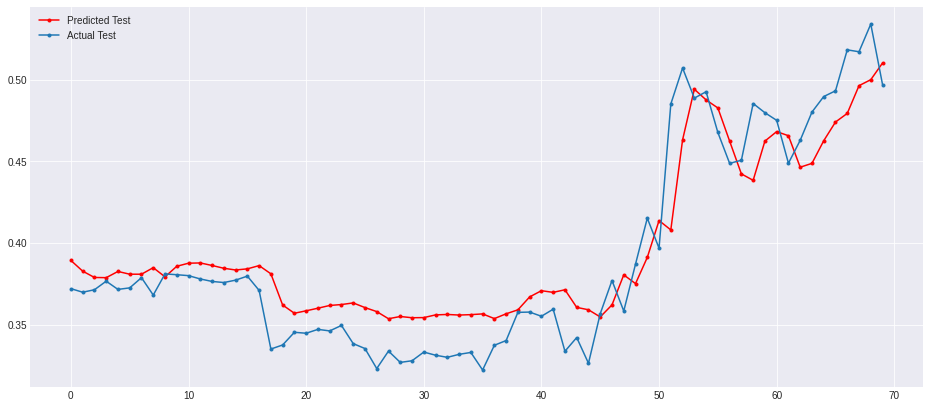

Test RMSE: 0.023
Test MAPE: 0.048
time: 177 ms (started: 2022-10-11 19:11:42 +00:00)


In [ ]:
plt.figure(figsize=(16,7))

plt.plot(predicted_test, 'r', marker='.', label='Predicted Test')

plt.plot(test_actual, marker='.', label='Actual Test')

plt.legend()
plt.show()

rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_test))
mape_lstm_test = mean_absolute_percentage_error(test_actual, predicted_test)

print('Test RMSE: %.3f' % rmse_lstm_test)
print('Test MAPE: %.3f' % mape_lstm_test)

# LSTM Prediction using trainX and plotting line graph against Actual trainY

In [ ]:
# Transformation to original form and making the predictions

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)

predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))

train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

In [ ]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')

plt.plot(train_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

# RMSE - Test Data

In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))
mape_lstm_test = mean_absolute_percentage_error(test_actual, predicted_btc_price_test_data)

print('Test RMSE: %.3f' % rmse_lstm_test)
print('Test MAPE: %.3f' % mape_lstm_test)

rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))
mape_lstm_train = mean_absolute_percentage_error(train_actual, predicted_btc_price_train_data)

print('Train RMSE: %.3f' % rmse_lstm_train)
print('Train MAPE: %.3f' % mape_lstm_train)


# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1666.162  => This seems best

In [ ]:
temp_input = testX[-1]
x_input = testX[-1]
print(x_input)
x_input=np.array(temp_input[1:])
print("{} day input {}".format(1,x_input))
x_input=x_input.reshape(1,-1)
# x_input = x_input.reshape((1, 10, 1))
LSTM_predicted_test = LSTM_model.predict(x_input)
GRU_predicted_test = GRU_model.predict(x_input)
LSTM_predicted_test

In [ ]:
from tensorflow.keras.models import load_model

LSTM_path = '/content/drive/My Drive/Models/LSTM_best_model.hdf5'
GRU_path = '/content/drive/My Drive/Models/GRU_best_model.hdf5'
meta_path = '/content/drive/My Drive/Models/meta_best_model.hdf5'

loaded_LSTM = load_model(LSTM_path)
loaded_GRU = load_model(GRU_path)
loaded_meta = load_model(meta_path)

LSTM_model = loaded_LSTM
GRU_model = loaded_GRU
meta_model = loaded_meta

[*********************100%***********************]  1 of 1 completed


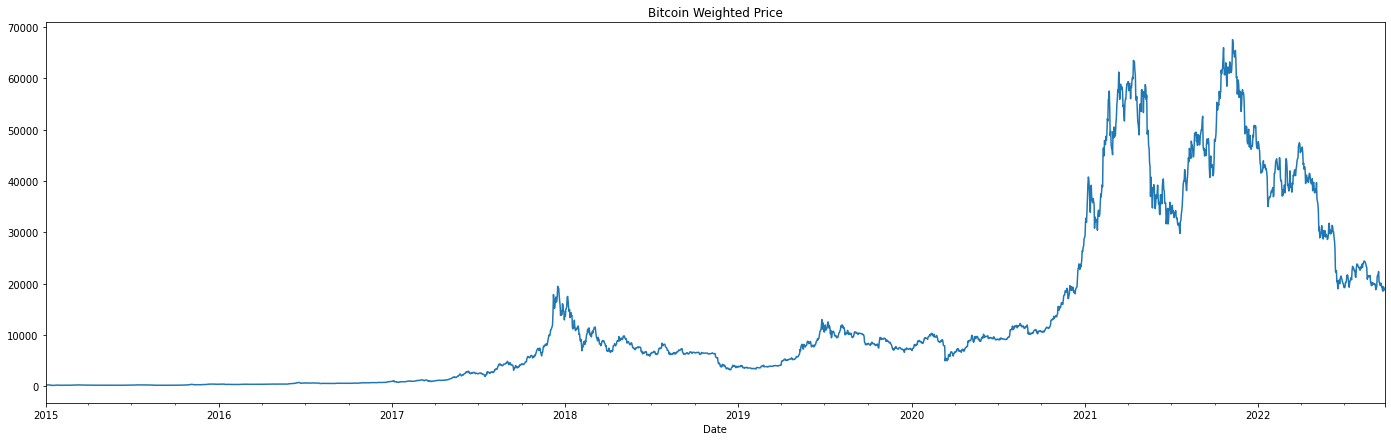

In [ ]:
from datetime import date
import yfinance as yf

START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

selected_stock = "BTC-USD"
data = load_data(selected_stock)
data
data.set_index("Date").Close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [ ]:
n_steps = 10
data['Close'][-n_steps:].values

array([19772.58398438, 20127.57617188, 19419.50585938, 19544.12890625,
       18890.7890625 , 18547.40039062, 19413.55078125, 19297.63867188,
       18937.01171875, 18802.09765625])

In [ ]:
n_steps = 10

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(data['Close'][-n_steps:].values.reshape(-1,1))

In [ ]:
data['Close'][-n_steps:].values

array([19772.58398438, 20127.57617188, 19419.50585938, 19544.12890625,
       18890.7890625 , 18547.40039062, 19413.55078125, 19297.63867188,
       18937.01171875, 18802.09765625])

11
[[18901.8189324 ]
 [18907.74571616]
 [18914.08637594]
 [18923.44905827]
 [18935.01630091]
 [18949.65845143]
 [18963.526371  ]
 [18972.47039737]
 [18979.83789447]
 [18987.61707777]]


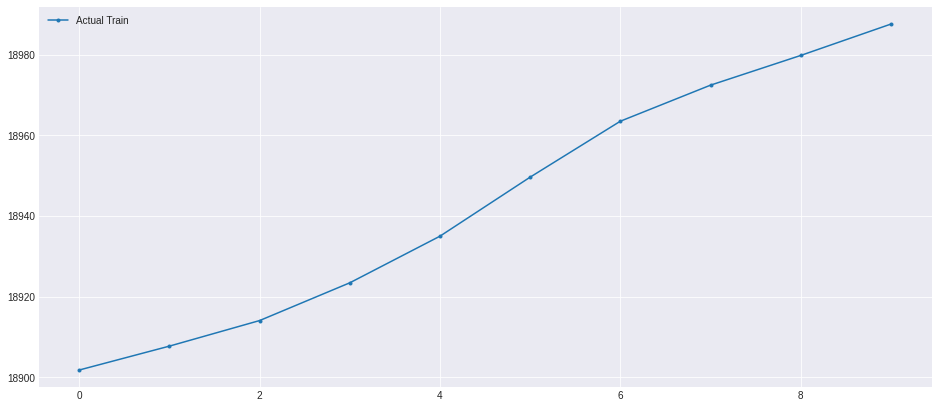

In [ ]:
n_steps = 10

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(data['Close'][-n_steps:].values.reshape(-1,1))

prediction_period = 10
temp_input = scaled_test
x_input = scaled_test
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]

i=0
while(i<prediction_period):
    
    if(len(temp_input)>n_steps):
        # print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        # yhat = model_from_saved_checkpoint.predict(x_input, verbose=0)
        yhat1 = LSTM_model.predict(x_input, verbose=0)
        yhat2 = GRU_model.predict(x_input, verbose=0)
        level1_test_data = np.concatenate((yhat1, yhat2), axis=-1)
        yhat = meta_model.predict(level1_test_data)

        
        # print("x = ", x_input)
        # print("{} day output {}".format(i,yhat))
        # temp_input.extend(yhat[0].tolist())
        temp_input = np.append(temp_input, yhat[0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        # yhat = model_from_saved_checkpoint.predict(x_input, verbose=0)
        yhat1 = LSTM_model.predict(x_input, verbose=0)
        yhat2 = GRU_model.predict(x_input, verbose=0)
        level1_test_data = np.concatenate((yhat1, yhat2), axis=-1)
        yhat = meta_model.predict(level1_test_data)
        
        # print(yhat[0])
        # temp_input.extend(yhat[0].tolist())
        temp_input = np.append(temp_input, yhat[0])
        lst_output.extend(yhat.tolist())
        i=i+1
    

lst_output = np.array(lst_output)
lst_output = scaler_test.inverse_transform(lst_output.reshape(-1, 1))
print(lst_output)

plt.figure(figsize=(16,7))


plt.plot(lst_output, marker='.', label='Actual Train')

plt.legend()
plt.show()

In [ ]:
df = pd.DataFrame(lst_output)[0]
df

0    18901.818932
1    18907.745716
2    18914.086376
3    18923.449058
4    18935.016301
5    18949.658451
6    18963.526371
7    18972.470397
8    18979.837894
9    18987.617078
Name: 0, dtype: float64